# **High-Frequency Quasi-Periodic Oscillations in the Solar Corona Observed with High-Frame-Rate Imaging During the 2023 Total Solar Eclipse**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

---
### **Notebook 4.0**
#### img registration 1st. 
- input: *.jpg
- output: *.png, *.mp4,  and  *.fits

STEP 1: file load. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path0 = '/Volumes/WD1T/share/TSE2023/'                  # input dir
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    # input dir
pathfd  = path0 + 'iPhone/result/dfdatat/'              # pahtfd = path with flat and dark processed

dirr1t = path1 + 'r1dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr1t):
    os.makedirs(dirr1t)
    
dirr2t = path1 + 'r2dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t):
    os.makedirs(dirr2t)
    
dirr2t_png = path1 + 'r2dfdatat_png/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t_png):
    os.makedirs(dirr2t_png)

In [3]:
# 5.0 data dark processing
pathd = dirr1t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r1_image_00000.fits', 'r1_image_00001.fits', 'r1_image_00002.fits', 'r1_image_00003.fits', 'r1_image_00004.fits', 'r1_image_00005.fits', 'r1_image_00006.fits', 'r1_image_00007.fits', 'r1_image_00008.fits', 'r1_image_00009.fits']
13301


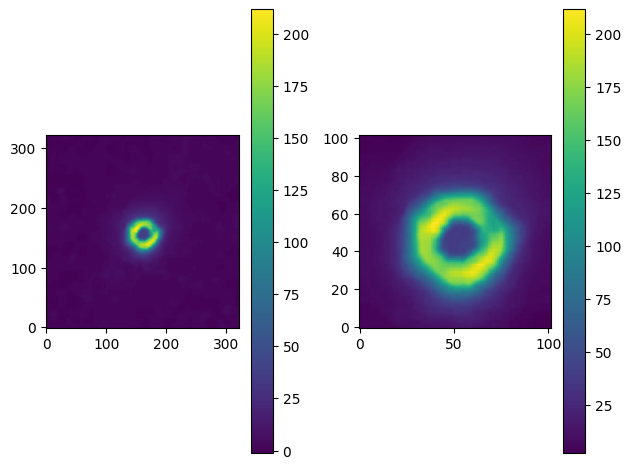

In [4]:
st1 = st + 0
hdu = fits.open(pathd + listd[st1+ 2800])
img = hdu[0].data

m,n = img.shape
rs = 17
srs = rs * 3                  # srs = 3 * radii of the Sun
sr,er,sc,ec = int(m/2) - srs,int(m/2) + srs, int(n/2) - srs,int(n/2) + srs

plt.subplot(121)
plt.imshow(img,origin = 'lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(img[sr:er, sc:ec],origin = 'lower')
plt.colorbar()
plt.tight_layout()


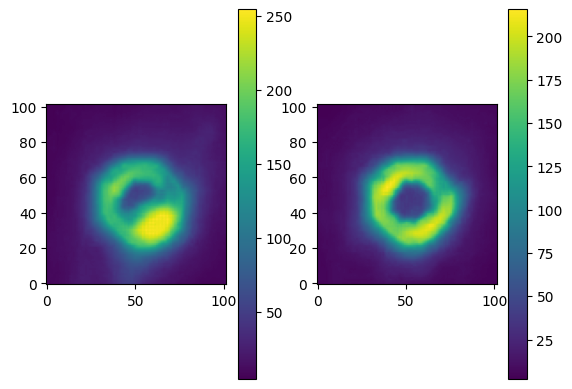

In [5]:
st1 = st + 0
hdu = fits.open(pathd + listd[st1])
img = hdu[0].data

hdu2 = fits.open(pathd + listd[st + 3282])
img2 = hdu2[0].data

plt.subplot(121)
plt.imshow(img[sr:er, sc:ec],origin = 'lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(img2[sr:er, sc:ec],origin = 'lower')
plt.colorbar()

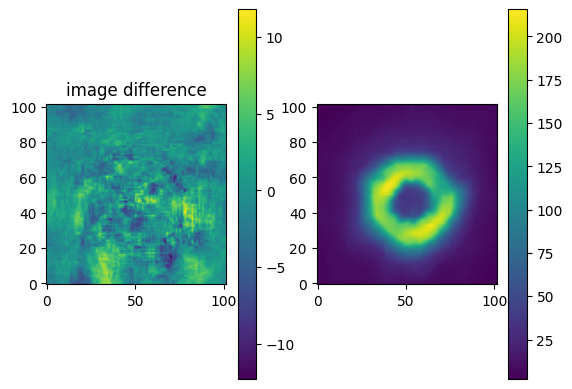

In [6]:
hdu1 = fits.open(pathd + listd[st + 0])
img1 = hdu1[0].data
image0 = img1#[sr:er, sc:ec]
hdu1 = fits.open(pathd + listd[st + 1])
img1 = hdu1[0].data
image1 = img1#[sr:er, sc:ec]
image = image1 - image0

plt.subplot(121)
plt.imshow(image[sr:er, sc:ec],origin = 'lower')
plt.title('image difference')
plt.colorbar()
plt.subplot(122)
plt.imshow(img2[sr:er, sc:ec],origin = 'lower')
plt.colorbar()


---
### **Notebook 4.0**
#### img registration 2nd. 
- input: *.jpg
- output: *.png, *.mp4,  and  *.fits

STEP 2: binary the coronal file, and then registration. 

In [7]:
# binary
def binim3(inputimg,thr):     
    inputimg[np.where(inputimg > thr)] = 255
    inputimg[np.where(inputimg < thr + 1)] = 0
    return inputimg

(322, 322)
[24.40736   24.873322  24.871868  23.601042  22.732693  22.073763
 21.208735  19.608883  17.936008  16.835846  16.620237  16.912975
 16.581158  15.456211  14.825762  14.122063  14.151607  13.336881
 13.243902  12.602894  11.962654  12.0971575 11.353149  10.44352
 10.283058   9.303694   9.075781   9.066543   9.30274    8.814206
  8.440564   8.453972   8.522831   8.481177   9.109988   8.825606
  8.509095   9.017892   9.056003   9.057528   8.2347355  8.225218
  8.0793915  8.316179   8.791964   8.6446085  8.342795   8.38414
  8.515617   8.585603 ]
(322, 322) >f4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


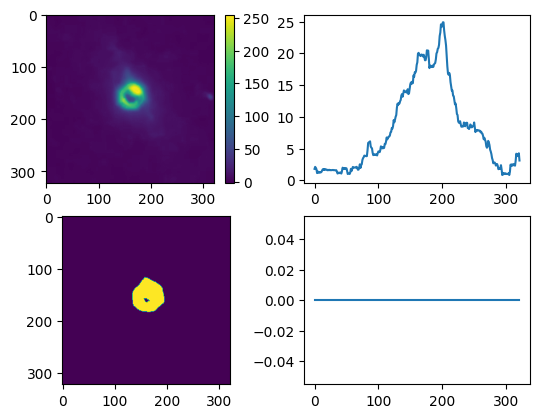

In [8]:
hdu = fits.open(pathd + listd[st + 0])
img = hdu[0].data
#bimg = binim(img)
# frame = img
# k = 5

print(img.shape)

plt.subplot(221)
plt.imshow(img)
plt.colorbar()
plt.subplot(222)
plt.plot(img[200,:])
print(img[200,200:250])
plt.subplot(223)
bimg = binim3(img, 60)
#print(T.shape, T.dtype)
print(bimg.shape, bimg.dtype)
plt.imshow(bimg)
plt.subplot(224)
plt.plot(bimg[200,:])
print(bimg[200,200:250])


[8.968618  9.127633  9.109891  9.089103  9.139946  8.415683  8.221184
 8.773471  8.05829   7.9482193 7.544444  6.6748633 6.8674397 5.3258543
 5.0435386 5.238016  4.879907  4.771707  5.120778  5.155394  5.148966
 4.8365045 4.773643  4.2602687 4.083868  4.794687  4.170024  2.8087962
 2.5437293 1.9113055 1.7728842 1.8578396 1.8261392 1.8655723 1.8557351
 1.8569515 1.8282686 1.8315672 1.8608131 1.7828193 2.4020693 2.4987307
 2.4434505 2.443707  2.4707637 1.9332546 1.8106965 1.8954343 1.8330715
 1.8882098]
(322, 322) >f4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


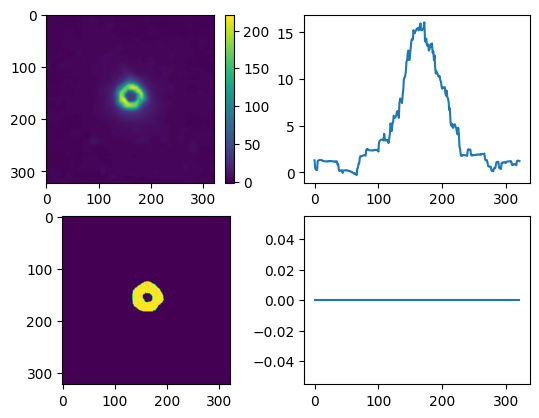

In [9]:
hdu = fits.open(pathd + listd[6000])
img = hdu[0].data

plt.subplot(221)
plt.imshow(img)
plt.colorbar()
plt.subplot(222)
plt.plot(img[200,:])
print(img[200,200:250])
plt.subplot(223)
bimg = binim3(img, 60)
#print(T.shape, T.dtype)
print(bimg.shape, bimg.dtype)
plt.imshow(bimg)
plt.subplot(224)
plt.plot(bimg[200,:])
print(bimg[200,200:250])

[23.145876  17.87879   16.276085  15.161538  14.613396  13.548763
 13.328713  12.775694  12.365921  10.79955   10.203743   8.192017
  7.9174433  7.0218396  7.673037   7.1047215  7.6631923  7.084817
  7.7950726  7.448953   7.913446   7.286637   8.405825   7.21223
  5.9418263  5.703787   5.7810807  5.6919165  5.4957523  4.9244432
  5.3798766  4.608478   4.581069   4.2886643  4.1909523  4.1421895
  4.1570973  4.0490713  4.1529274  4.0306573  4.1299577  4.05862
  4.115086   4.0360975  3.9449074  3.6837456  3.8529694  3.749253
  3.800748   3.7695506]
(322, 322) >f4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


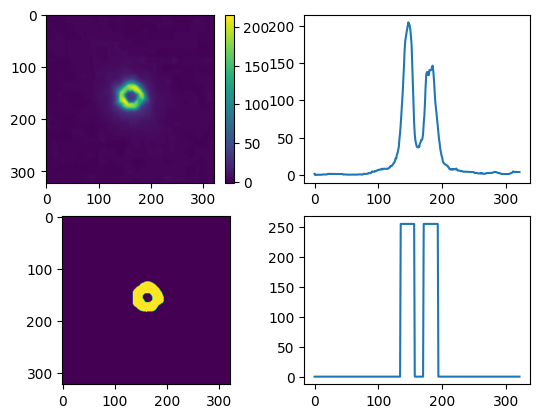

In [10]:
hdu = fits.open(pathd + listd[3282])
img = hdu[0].data

plt.subplot(221)
plt.imshow(img)
plt.colorbar()
plt.subplot(222)
plt.plot(img[int(m/2),:])
print(img[int(m/2),200:250])
plt.subplot(223)
bimg = binim3(img, 60)
#print(T.shape, T.dtype)
print(bimg.shape, bimg.dtype)
plt.imshow(bimg)
plt.subplot(224)
plt.plot(bimg[int(m/2),:])
print(bimg[int(m/2),200:250])

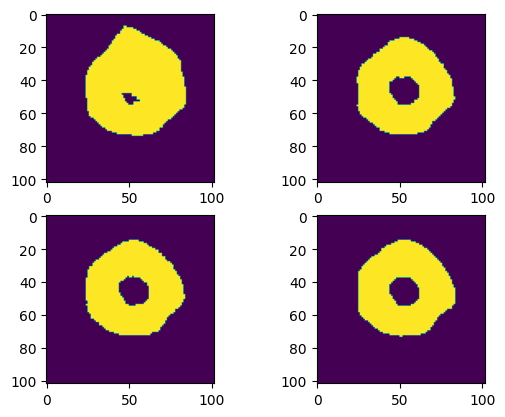

In [11]:
csr, cer, csc, cec = sr,er,sc,ec
#csr, cer, csc, cec = 150,350, 160,360

hdu = fits.open(pathd + listd[0])
img = hdu[0].data
plt.subplot(221)
plt.imshow(binim3(img[csr:cer, csc:cec],60)) 
hdu = fits.open(pathd + listd[3000])
img = hdu[0].data
plt.subplot(222)
plt.imshow(binim3(img[csr:cer, csc:cec],60)) 
hdu = fits.open(pathd + listd[6000])
img = hdu[0].data
plt.subplot(223)
plt.imshow(binim3(img[csr:cer, csc:cec],60))  
hdu = fits.open(pathd + listd[3282])
img = hdu[0].data
plt.subplot(224)
plt.imshow(binim3(img[csr:cer, csc:cec],60)) 

In [12]:
# cross correction test
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

fg = 1                  # file gap 
fnu = int(fn / fg)      # fnu: file name useful
print(fnu,st)

13301 0


In [13]:
pathd, listd

('/Volumes/WD1T/share/TSE2023/iPhone/result/r1dfdatat/',
 ['r1_image_00000.fits',
  'r1_image_00001.fits',
  'r1_image_00002.fits',
  'r1_image_00003.fits',
  'r1_image_00004.fits',
  'r1_image_00005.fits',
  'r1_image_00006.fits',
  'r1_image_00007.fits',
  'r1_image_00008.fits',
  'r1_image_00009.fits',
  'r1_image_00010.fits',
  'r1_image_00011.fits',
  'r1_image_00012.fits',
  'r1_image_00013.fits',
  'r1_image_00014.fits',
  'r1_image_00015.fits',
  'r1_image_00016.fits',
  'r1_image_00017.fits',
  'r1_image_00018.fits',
  'r1_image_00019.fits',
  'r1_image_00020.fits',
  'r1_image_00021.fits',
  'r1_image_00022.fits',
  'r1_image_00023.fits',
  'r1_image_00024.fits',
  'r1_image_00025.fits',
  'r1_image_00026.fits',
  'r1_image_00027.fits',
  'r1_image_00028.fits',
  'r1_image_00029.fits',
  'r1_image_00030.fits',
  'r1_image_00031.fits',
  'r1_image_00032.fits',
  'r1_image_00033.fits',
  'r1_image_00034.fits',
  'r1_image_00035.fits',
  'r1_image_00036.fits',
  'r1_image_00037.

---
### **Notebook 4.0**
#### img registration 2nd. 
- input: *.jpg
- output: *.png, *.mp4,  and  *.fits

STEP 3: calculate the shift value 2nd time（Precise）, and then registration. 

In [14]:
# registration 1st
fg = 1                  # file gap 
fnu = int(fn / fg)      # fnu: file name useful
frmshift = np.zeros([2, fnu])
hdu1 = fits.open(pathd + listd[st + 3000])
img1 = hdu1[0].data
#csr, cer, csc, cec = 150,190, 180,260
image = binim3(img1[csr:cer, csc:cec],60)  
for i in range(fnu):
    hdu2 = fits.open(pathd + listd[st + i])
    img2 = hdu2[0].data
    #offset_image = pca_stokes(img2, 0.90)
    offset_image = binim3(img2[csr:cer, csc:cec],60)  
    shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                upsample_factor=100)
    print(f'Detected shift offset (y, x) of frame',i,listd[st + i], f'is : {shift}')
    frmshift[:, i] = shift
    
np.save(path1 + 'refer_frmshift_2nd.npy', frmshift)
frmshift = np.load(path1 + 'refer_frmshift_2nd.npy')

Detected shift offset (y, x) of frame 0 r1_image_00000.fits is : [-0.74 -2.01]
Detected shift offset (y, x) of frame 1 r1_image_00001.fits is : [ 7.05 -1.92]
Detected shift offset (y, x) of frame 2 r1_image_00002.fits is : [-0.5   0.03]
Detected shift offset (y, x) of frame 3 r1_image_00003.fits is : [-0.05  0.01]
Detected shift offset (y, x) of frame 4 r1_image_00004.fits is : [-0.15  0.27]
Detected shift offset (y, x) of frame 5 r1_image_00005.fits is : [-0.6  -1.75]
Detected shift offset (y, x) of frame 6 r1_image_00006.fits is : [-0.44  0.16]
Detected shift offset (y, x) of frame 7 r1_image_00007.fits is : [-0.36  0.52]
Detected shift offset (y, x) of frame 8 r1_image_00008.fits is : [-0.02  0.08]
Detected shift offset (y, x) of frame 9 r1_image_00009.fits is : [-0.34        0.48000002]
Detected shift offset (y, x) of frame 10 r1_image_00010.fits is : [-0.13  0.41]
Detected shift offset (y, x) of frame 11 r1_image_00011.fits is : [-0.24  0.48]
Detected shift offset (y, x) of frame 

(2, 13301)
0.09155928115636663 -0.041607397874041024
x slope: [ 9.07130782e-05 -5.11682689e-01]
y slope: [-1.78615646e-05  7.71720065e-02]


/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_13029/3724258759.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)
/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_13029/3724258759.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


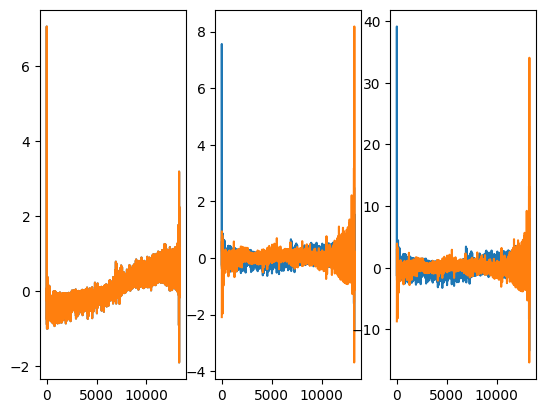

In [15]:
print(frmshift.shape)
plt.subplot(121)
plt.plot(frmshift[0,0:8000])
plt.subplot(122)
plt.plot(frmshift[1,0:8000])
print(np.mean(frmshift[0,:]), np.mean(frmshift[1,:]))


t0 = 0
dt = 1 # In seconds
# We also create a time array in years.
N = fnu
t = np.arange(0, N) * dt + t0

datx = frmshift[0,:]
daty = frmshift[1,:]

dat = datx
px = np.polyfit(t - t0, dat, 1)

dat_notrend = dat - np.polyval(px, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

plt.subplot(131)
plt.plot(datx)
plt.subplot(132)
plt.plot(dat_notrend)
plt.subplot(133)
plt.plot(dat_norm)
print('x slope:', px)

dat = daty
py = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(py, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

plt.subplot(131)
plt.plot(datx)
plt.subplot(132)
plt.plot(dat_notrend)
plt.subplot(133)
plt.plot(dat_norm)
print('y slope:', py)

x slope: [ 9.07130782e-05 -5.11682689e-01]
y slope: [-1.78615646e-05  7.71720065e-02]


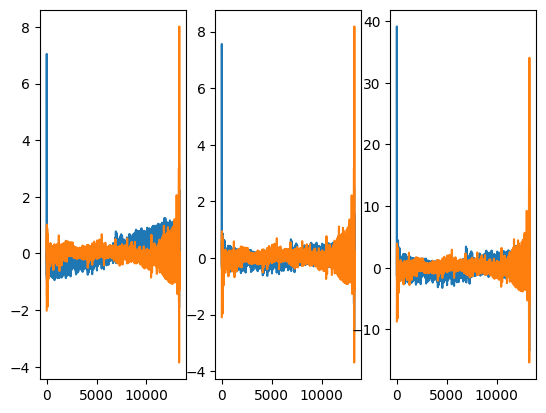

In [16]:
t0 = 0
dt = 1 # In seconds
# We also create a time array in years.
N = fnu
t = np.arange(0, N) * dt + t0

datx = frmshift[0,0:N]
daty = frmshift[1,0:N]

dat = datx
px = np.polyfit(t - t0, dat, 1)

dat_notrend = dat - np.polyval(px, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

plt.subplot(131)
plt.plot(datx)
plt.subplot(132)
plt.plot(dat_notrend)
plt.subplot(133)
plt.plot(dat_norm)
print('x slope:', px)

dat = daty
py = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(py, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

plt.subplot(131)
plt.plot(dat)
plt.subplot(132)
plt.plot(dat_notrend)
plt.subplot(133)
plt.plot(dat_norm)
print('y slope:', py)

(13301,)

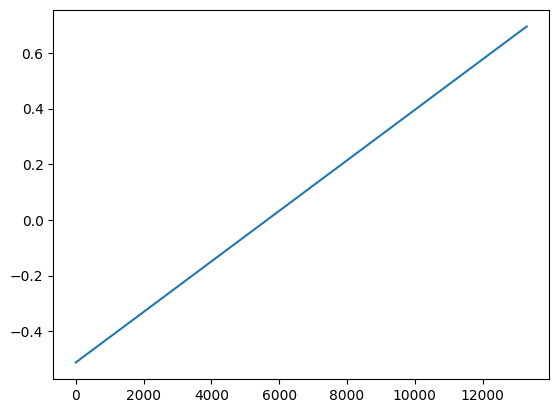

In [17]:
t0 = 0
dt = 1 # In seconds
# We also create a time array in years.
N = fnu
t = np.arange(0, N) * dt + t0

ax = np.polyval(px, t - t0)
ay = np.polyval(py, t - t0)

ax.dtype
plt.plot(ax)

ax.shape

(13301,) (13301,)


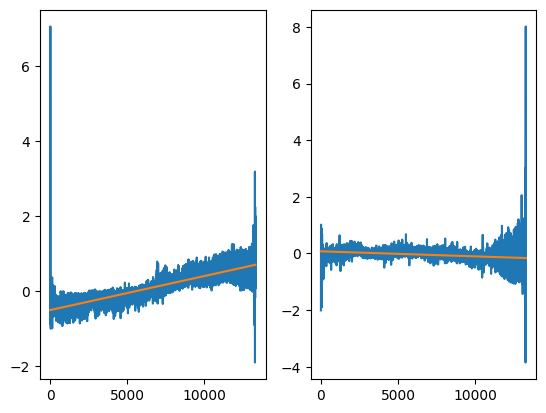

In [18]:
frmshift2 = np.zeros([2, fnu])
# dn = np.arange(fnu)
# print(dn[fnu-1])
# print(dn.size, frmshift.shape, frmshift2.shape)

frmshift2[0, :] = ax
frmshift2[1, :] = ay
# frmshift2 = np.zeros([2, fnu])

plt.subplot(121)
plt.plot(frmshift[0, :] )
plt.plot(ax)
plt.subplot(122)
plt.plot(frmshift[1, :])
plt.plot(ay)

print(ax.shape, ay.shape)
np.save(path1 + 'fit_frmshift_polyfit_2nd.npy', frmshift2)

In [19]:
pathd + listd[st + 0 * fg], 'r2_' + listd[st + 0 * fg] , 0*fg, dirr2t, dirr2t_png,fg,fnu

('/Volumes/WD1T/share/TSE2023/iPhone/result/r1dfdatat/r1_image_00000.fits',
 'r2_r1_image_00000.fits',
 0,
 '/Volumes/WD1T/share/TSE2023/iPhone/result/r2dfdatat/',
 '/Volumes/WD1T/share/TSE2023/iPhone/result/r2dfdatat_png/',
 1,
 13301)

---
### **Notebook 4.0**
#### img registration 1st. 
- input: *.jpg
- output: *.png, *.mp4,  and  *.fits

STEP 4: Image registration by the fitting results of the 2nd frames shift value - frmshift2. 
- Due to the large amount of data, the execution is performed in sections to avoid memory overflow

In [20]:
fg = 1
for i in range(0,2500):
    hdu = fits.open(pathd + listd[st + i * fg])
    img = hdu[0].data
    imgc = img#[sr:er, sc:ec]
    #sv = (ax[i * fg], ay[i * fg])
    sv = (frmshift[0,i * fg], frmshift[1,i * fg])
    offset1 = fourier_shift(np.fft.fftn(imgc), sv)
    offset1 = np.fft.ifftn(offset1)
    imgcr = offset1.real
    imgcr = imgcr.astype('float32')
    hdu1 = fits.PrimaryHDU()
    hdu1.data = imgcr
    new_hdu = fits.HDUList([hdu1])
    nname = 'r2_' + listd[st + i * fg]         # nname: new name
    new_hdu.writeto(dirr2t + nname, overwrite=True) 
    name = f'frame{str(i).zfill(5)}'
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow(imgc, origin='lower',cmap='gray') 
    tn1 = name + '  regisration 1st'
    plt.title(tn1)
    plt.subplot(122)
    plt.imshow(imgcr, origin='lower',cmap='gray') 
    tn2 = name + '  regisration 2nd'
    plt.title(tn2)
    plt.tight_layout()
    plt.savefig(dirr2t_png + 'r2_' + listd[st + i * fg] +'.png')
    plt.close()
    print('frame_sir2_'+ str(i*fg) +'.png', 'saved over.', sv)

frame_sir2_0.png saved over. (-0.7400000095367432, -2.009999990463257)
frame_sir2_1.png saved over. (7.050000190734863, -1.9199999570846558)
frame_sir2_2.png saved over. (-0.5, 0.029999999329447746)
frame_sir2_3.png saved over. (-0.05000000074505806, 0.009999999776482582)
frame_sir2_4.png saved over. (-0.15000000596046448, 0.27000001072883606)
frame_sir2_5.png saved over. (-0.6000000238418579, -1.75)
frame_sir2_6.png saved over. (-0.4399999976158142, 0.1599999964237213)
frame_sir2_7.png saved over. (-0.36000001430511475, 0.5199999809265137)
frame_sir2_8.png saved over. (-0.019999999552965164, 0.07999999821186066)
frame_sir2_9.png saved over. (-0.3400000035762787, 0.48000001907348633)
frame_sir2_10.png saved over. (-0.12999999523162842, 0.4099999964237213)
frame_sir2_11.png saved over. (-0.23999999463558197, 0.47999998927116394)
frame_sir2_12.png saved over. (-0.6699999570846558, 1.0199999809265137)
frame_sir2_13.png saved over. (-0.5, 0.1899999976158142)
frame_sir2_14.png saved over. (

In [21]:
fg = 1
for i in range(2500, 5000):
    hdu = fits.open(pathd + listd[st + i * fg])
    img = hdu[0].data
    imgc = img#[sr:er, sc:ec]
    sv = (ax[i * fg], ay[i * fg])
    offset1 = fourier_shift(np.fft.fftn(imgc), sv)
    offset1 = np.fft.ifftn(offset1)
    imgcr = offset1.real
    imgcr = imgcr.astype('float32')
    hdu1 = fits.PrimaryHDU()
    hdu1.data = imgcr
    new_hdu = fits.HDUList([hdu1])
    nname = 'r2_' + listd[st + i * fg]         # nname: new name
    new_hdu.writeto(dirr2t + nname, overwrite=True) 
    name = f'frame{str(i).zfill(5)}'
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow(imgc, origin='lower',cmap='gray') 
    tn1 = name + '  regisration 1st'
    plt.title(tn1)
    plt.subplot(122)
    plt.imshow(imgcr, origin='lower',cmap='gray') 
    tn2 = name + '  regisration 2nd'
    plt.title(tn2)
    plt.tight_layout()
    plt.savefig(dirr2t_png + 'r2_' + listd[st + i * fg] +'.png')
    plt.close()
    print('frame_sir2_'+ str(i*fg) +'.png', 'saved over.', sv)

frame_sir2_2500.png saved over. (-0.2848999932630687, 0.032518095111378834)
frame_sir2_2501.png saved over. (-0.2848092801848954, 0.032500233546804036)
frame_sir2_2502.png saved over. (-0.284718567106722, 0.03248237198222924)
frame_sir2_2503.png saved over. (-0.2846278540285486, 0.032464510417654434)
frame_sir2_2504.png saved over. (-0.2845371409503753, 0.032446648853079636)
frame_sir2_2505.png saved over. (-0.284446427872202, 0.03242878728850484)
frame_sir2_2506.png saved over. (-0.28435571479402855, 0.032410925723930034)
frame_sir2_2507.png saved over. (-0.2842650017158552, 0.03239306415935524)
frame_sir2_2508.png saved over. (-0.2841742886376819, 0.03237520259478044)
frame_sir2_2509.png saved over. (-0.28408357555950847, 0.032357341030205634)
frame_sir2_2510.png saved over. (-0.28399286248133515, 0.03233947946563084)
frame_sir2_2511.png saved over. (-0.28390214940316183, 0.03232161790105604)
frame_sir2_2512.png saved over. (-0.2838114363249884, 0.032303756336481235)
frame_sir2_2513.

In [22]:
import gc

# 执行垃圾回收
gc.collect()

17008547

In [23]:
fg = 1
for i in range(5000, 7500):
    hdu = fits.open(pathd + listd[st + i * fg])
    img = hdu[0].data
    imgc = img#[sr:er, sc:ec]
    sv = (ax[i * fg], ay[i * fg])
    offset1 = fourier_shift(np.fft.fftn(imgc), sv)
    offset1 = np.fft.ifftn(offset1)
    imgcr = offset1.real
    imgcr = imgcr.astype('float32')
    hdu1 = fits.PrimaryHDU()
    hdu1.data = imgcr
    new_hdu = fits.HDUList([hdu1])
    nname = 'r2_' + listd[st + i * fg]         # nname: new name
    new_hdu.writeto(dirr2t + nname, overwrite=True) 
    name = f'frame{str(i).zfill(5)}'
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow(imgc, origin='lower',cmap='gray') 
    tn1 = name + '  regisration 1st'
    plt.title(tn1)
    plt.subplot(122)
    plt.imshow(imgcr, origin='lower',cmap='gray') 
    tn2 = name + '  regisration 2nd'
    plt.title(tn2)
    plt.tight_layout()
    plt.savefig(dirr2t_png + 'r2_' + listd[st + i * fg] +'.png')
    plt.close()
    print('frame_sir2_'+ str(i*fg) +'.png', listd[st + i * fg],'saved over.', sv)

frame_sir2_5000.png r1_image_05000.fits saved over. (-0.05811729782967395, -0.012135816325621052)
frame_sir2_5001.png r1_image_05001.fits saved over. (-0.058026584751500576, -0.01215367789019585)
frame_sir2_5002.png r1_image_05002.fits saved over. (-0.057935871673327255, -0.012171539454770647)
frame_sir2_5003.png r1_image_05003.fits saved over. (-0.05784515859515388, -0.012189401019345444)
frame_sir2_5004.png r1_image_05004.fits saved over. (-0.0577544455169805, -0.012207262583920242)
frame_sir2_5005.png r1_image_05005.fits saved over. (-0.05766373243880718, -0.01222512414849504)
frame_sir2_5006.png r1_image_05006.fits saved over. (-0.057573019360633804, -0.012242985713069851)
frame_sir2_5007.png r1_image_05007.fits saved over. (-0.05748230628246043, -0.012260847277644649)
frame_sir2_5008.png r1_image_05008.fits saved over. (-0.057391593204287106, -0.012278708842219446)
frame_sir2_5009.png r1_image_05009.fits saved over. (-0.05730088012611373, -0.012296570406794244)
frame_sir2_5010.png

In [24]:
# 执行垃圾回收
gc.collect()

17008213

In [25]:
fg = 1
for i in range(7500, 10000):
    hdu = fits.open(pathd + listd[st + i * fg])
    img = hdu[0].data
    imgc = img#[sr:er, sc:ec]
    sv = (ax[i * fg], ay[i * fg])
    offset1 = fourier_shift(np.fft.fftn(imgc), sv)
    offset1 = np.fft.ifftn(offset1)
    imgcr = offset1.real
    imgcr = imgcr.astype('float32')
    hdu1 = fits.PrimaryHDU()
    hdu1.data = imgcr
    new_hdu = fits.HDUList([hdu1])
    nname = 'r2_' + listd[st + i * fg]         # nname: new name
    new_hdu.writeto(dirr2t + nname, overwrite=True) 
    name = f'frame{str(i).zfill(5)}'
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow(imgc, origin='lower',cmap='gray') 
    tn1 = name + '  regisration 1st'
    plt.title(tn1)
    plt.subplot(122)
    plt.imshow(imgcr, origin='lower',cmap='gray') 
    tn2 = name + '  regisration 2nd'
    plt.title(tn2)
    plt.tight_layout()
    plt.savefig(dirr2t_png + 'r2_' + listd[st + i * fg] +'.png')
    plt.close()
    print('frame_sir2_'+ str(i*fg) +'.png', listd[st + i * fg],'saved over.', sv)

frame_sir2_7500.png r1_image_07500.fits saved over. (0.1686653976037208, -0.05678972776262092)
frame_sir2_7501.png r1_image_07501.fits saved over. (0.1687561106818941, -0.056807589327195734)
frame_sir2_7502.png r1_image_07502.fits saved over. (0.16884682376006754, -0.05682545089177052)
frame_sir2_7503.png r1_image_07503.fits saved over. (0.16893753683824086, -0.05684331245634533)
frame_sir2_7504.png r1_image_07504.fits saved over. (0.16902824991641419, -0.05686117402092014)
frame_sir2_7505.png r1_image_07505.fits saved over. (0.16911896299458762, -0.056879035585494925)
frame_sir2_7506.png r1_image_07506.fits saved over. (0.16920967607276094, -0.056896897150069736)
frame_sir2_7507.png r1_image_07507.fits saved over. (0.16930038915093426, -0.05691475871464452)
frame_sir2_7508.png r1_image_07508.fits saved over. (0.1693911022291077, -0.05693262027921933)
frame_sir2_7509.png r1_image_07509.fits saved over. (0.16948181530728101, -0.056950481843794115)
frame_sir2_7510.png r1_image_07510.fits

In [26]:
# 执行垃圾回收
gc.collect()

17008210

In [27]:
fg = 1
for i in range(10000, fnu):
    hdu = fits.open(pathd + listd[st + i * fg])
    img = hdu[0].data
    imgc = img#[sr:er, sc:ec]
    sv = (ax[i * fg], ay[i * fg])
    offset1 = fourier_shift(np.fft.fftn(imgc), sv)
    offset1 = np.fft.ifftn(offset1)
    imgcr = offset1.real
    imgcr = imgcr.astype('float32')
    hdu1 = fits.PrimaryHDU()
    hdu1.data = imgcr
    new_hdu = fits.HDUList([hdu1])
    nname = 'r2_' + listd[st + i * fg]         # nname: new name
    new_hdu.writeto(dirr2t + nname, overwrite=True) 
    name = f'frame{str(i).zfill(5)}'
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow(imgc, origin='lower',cmap='gray') 
    tn1 = name + '  regisration 1st'
    plt.title(tn1)
    plt.subplot(122)
    plt.imshow(imgcr, origin='lower',cmap='gray') 
    tn2 = name + '  regisration 2nd'
    plt.title(tn2)
    plt.tight_layout()
    plt.savefig(dirr2t_png + 'r2_' + listd[st + i * fg] +'.png')
    plt.close()
    print('frame_sir2_'+ str(i*fg) +'.png',listd[st + i * fg], 'saved over.', sv)

frame_sir2_10000.png r1_image_10000.fits saved over. (0.3954480930371156, -0.10144363919962082)
frame_sir2_10001.png r1_image_10001.fits saved over. (0.3955388061152889, -0.1014615007641956)
frame_sir2_10002.png r1_image_10002.fits saved over. (0.39562951919346234, -0.10147936232877042)
frame_sir2_10003.png r1_image_10003.fits saved over. (0.39572023227163566, -0.1014972238933452)
frame_sir2_10004.png r1_image_10004.fits saved over. (0.395810945349809, -0.10151508545792001)
frame_sir2_10005.png r1_image_10005.fits saved over. (0.3959016584279824, -0.10153294702249482)
frame_sir2_10006.png r1_image_10006.fits saved over. (0.39599237150615574, -0.10155080858706961)
frame_sir2_10007.png r1_image_10007.fits saved over. (0.39608308458432906, -0.10156867015164442)
frame_sir2_10008.png r1_image_10008.fits saved over. (0.3961737976625025, -0.1015865317162192)
frame_sir2_10009.png r1_image_10009.fits saved over. (0.3962645107406758, -0.10160439328079401)
frame_sir2_10010.png r1_image_10010.fits

In [28]:
print(pathd, listd[0])
print(dirr2t, nname)

/Volumes/WD1T/share/TSE2023/iPhone/result/r1dfdatat/ r1_image_00000.fits
/Volumes/WD1T/share/TSE2023/iPhone/result/r2dfdatat/ r2_r1_image_13300.fits


---
### **Notebook 4.0**
#### img registration 1st. 
- input: *.jpg
- output: *.png, *.mp4,  and  *.fits

STEP 5: output the regitstration result - r2_r1_fddata.mp4. 

In [29]:
import os
import glob

# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t_png, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [30]:
import numpy as np
import cv2
from PIL import Image

fps = 240*5.6

image_folder = dirr2t_png
video_name = 'r2_r1_fddata.mp4'  # registration, polarization dark flat processed data of before

# Collect all PNG images and sort them alphabetically (or by filename)
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()  # Ensure images are in the correct order

# Read the first image to get the size
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Using 'mp4v' for MP4 format
video = cv2.VideoWriter(os.path.join(path1, video_name), fourcc, fps, (width, height))

# Loop through images and write them to the video
for image in images[480:12960]:
    img_path = os.path.join(image_folder, image)
    img = cv2.imread(img_path)
    video.write(img)

# Release the video writer and close any OpenCV windows
cv2.destroyAllWindows()
video.release()